In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import torch
import os
import pickle as pkl
os.chdir('/content/drive/MyDrive/JSALT/DynamicalVAE/DVAE')
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import numpy as np
from copy import deepcopy
from typing import List, Union
import random
from collections import Counter
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

!pip install ipympl
!pip install sentence-transformers==2.2.2
!pip install datasets
!pip install pystoi
!pip install https://github.com/vBaiCai/python-pesq/archive/master.zip
!pip3 install graphviz


from dvae.model import build_VAE, build_DKF, build_STORN, build_VRNN, build_SRNN, build_RVAE, build_DSAE
import graphviz
from dvae.model import vrnn,srnn
from dvae import learning_algo,learning_algo_new
from sklearn.cluster import KMeans

In [3]:
!pip freeze > reqs.txt


# Test

In [ ]:
!python train_model.py --cfg ./config/speech/cfg_rvae_Causal.ini

Traceback (most recent call last):
  File "/content/drive/MyDrive/JSALT/DynamicalVAE/DVAE/train_model.py", line 13, in <module>
    from dvae.learning_algo_ss import LearningAlgorithm_ss
  File "/content/drive/MyDrive/JSALT/DynamicalVAE/DVAE/dvae/learning_algo_ss.py", line 22, in <module>
    from .model_ss import build_SRNN_ss
  File "<frozen importlib._bootstrap>", line 1027, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1006, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 688, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 879, in exec_module
  File "<frozen importlib._bootstrap_external>", line 975, in get_code
  File "<frozen importlib._bootstrap_external>", line 1074, in get_data
KeyboardInterrupt
^C


In [ ]:
train_dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
        transform=transforms.ToTensor()),
    batch_size=16, shuffle=True)

In [ ]:
from dvae.model import vrnn,srnn

x_dim = 28
z_dim = 16
device = 'cpu'
dvae_model = vrnn.VRNN(x_dim=x_dim, z_dim=z_dim).to(device)
model_info = dvae_model.get_info()
#print(model_info)
dvae_model

VRNN(
  (activation): Tanh()
  (feature_extractor_x): Sequential(
    (linear0): Linear(in_features=28, out_features=128, bias=True)
    (activation0): Tanh()
    (dropout0): Dropout(p=0, inplace=False)
  )
  (feature_extractor_z): Sequential(
    (linear0): Linear(in_features=16, out_features=128, bias=True)
    (activation0): Tanh()
    (dropout0): Dropout(p=0, inplace=False)
  )
  (mlp_hx_z): Sequential(
    (linear0): Linear(in_features=256, out_features=128, bias=True)
    (activation0): Tanh()
    (dropout0): Dropout(p=0, inplace=False)
  )
  (inf_mean): Linear(in_features=128, out_features=16, bias=True)
  (inf_logvar): Linear(in_features=128, out_features=16, bias=True)
  (mlp_h_z): Sequential(
    (linear0): Linear(in_features=128, out_features=128, bias=True)
    (activation0): Tanh()
    (dropout0): Dropout(p=0, inplace=False)
  )
  (prior_mean): Linear(in_features=128, out_features=16, bias=True)
  (prior_logvar): Linear(in_features=128, out_features=16, bias=True)
  (mlp_h

In [ ]:
from dvae.utils import myconf, get_logger, loss_ISD, loss_KLD, loss_MPJPE

torch.Size([16, 1, 28, 28])


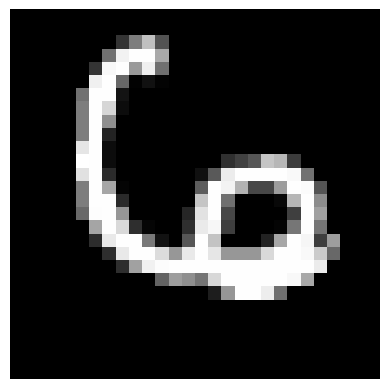

AttributeError: ignored

In [ ]:
for batch, (X,y) in enumerate(train_dataloader):
  print(X.shape)

  plt.axis("off")
  plt.imshow(X[0].squeeze(), cmap="gray")
  plt.show()
  X = X.squeeze(1)
  X = X.permute(2, 0, 1)



  out = dvae_model(X)
  print(out.shape)
  plt.axis("off")
  plt.imshow(out[0].detach().numpy(), cmap="gray")
  plt.show()


  break

# Create data

In [ ]:
from datasets import load_dataset
from sentence_transformers import SentenceTransformer

multiwoz_dset = load_dataset("multi_woz_v22")

In [ ]:
utterances = []
ids = []

for n, i in enumerate(multiwoz_dset['test']):
  print(n)
  utterances.append(i['turns']['utterance'])
  ids.append(i['dialogue_id'])

In [ ]:
model = SentenceTransformer("sentence-transformers/LaBSE")

model.cuda()

In [ ]:
df = pd.DataFrame(list(zip(ids, utterances)), columns =['id', 'utterances'])

In [ ]:
df['embeds'] = df.utterances.apply(lambda x : model.encode(x))

In [ ]:
df.to_pickle('/content/drive/MyDrive/JSALT/DynamicalVAE/data/multiwoz_sentence_embeds_test.pkl')

In [ ]:
df = pd.read_pickle('/content/drive/MyDrive/JSALT/DynamicalVAE/data/multiwoz_sentence_embeds_val.pkl')

# Experiment

In [ ]:
# train_dataloader = torch.utils.data.DataLoader(
#     datasets.MNIST('data', train=True, download=True,
#         transform=transforms.ToTensor()),
#     batch_size=2, shuffle=True)
#
# val_dataloader = torch.utils.data.DataLoader(
#     datasets.MNIST('data', train=False, download=True,
#         transform=transforms.ToTensor()),
#     batch_size=2, shuffle=False)

In [ ]:
class LoadDataset (Dataset):
  def __init__(self,data, train = False):
    self.data = data
    if train :
      self.data = data.sample(frac = 1)

  def __len__(self):
    return self.data.shape[0]

  def __getitem__(self,i):
    return self.data.iloc[i]

def collate_data(data):
  ids = []
  tensors = []

  max = 0
  pad = np.zeros(768)

  for i in data:
    ids.append(i[0])

    if i[2].shape[0] > max:
      max = i[2].shape[0]


  for i in data:
    shape = i[2].shape[0]
    arr = i[2]

    for j in range( shape , max):
      arr=np.vstack([arr, pad])

    tensors.append(arr)

  tensors = np.array(tensors)
  tensors = torch.tensor(tensors).float()

  return ids, tensors


train_data = LoadDataset(pd.read_pickle('/content/drive/MyDrive/JSALT/DynamicalVAE/data/multiwoz_sentence_embeds_train.pkl'), True)
train_loader = DataLoader(train_data, 32, True, collate_fn=collate_data )

val_data = LoadDataset(pd.read_pickle('/content/drive/MyDrive/JSALT/DynamicalVAE/data/multiwoz_sentence_embeds_val.pkl'))
val_loader = DataLoader(val_data, 32, True, collate_fn=collate_data )

In [ ]:
params = {}
params['cfg'] = './config/speech/cfg_vrnn.ini'
params['pretrain_dict'] = None
params['model_dir'] = './saved_model/WSJ0_2023-08-01-14h06_VRNN_z_dim=16'
params['reload'] = True

learning = learning_algo_new.LearningAlgorithm(params, train_loader, val_loader)

Running EXP 2.8


In [ ]:
learning.train()

Running on cuda


INFO:root:HOSTNAME: ee270901721e
INFO:root:Time: 2023-08-07-08h01
INFO:root:Device for training: cuda
INFO:root:Cuda verion: 11.8
INFO:root:Model name: VRNN
INFO:root:Total params: 0.74M
INFO:root:In this experiment, result will be saved in: ./saved_model/WSJ0_2023-08-01-14h06_VRNN_z_dim=16
INFO:root:Resuming trainning: epoch: 49
INFO:root:KL warm-up, anneal coeff: 1.0


kl_warm is 0.8
~~~~~~~~~~~~~~~~~~~~~~ Running epoch 50 ~~~~~~~~~~~~~~~~~~~~~~
batch running [ 0 / 264 ] || Total loss  8.024880409240723
batch running [ 25 / 264 ] || Total loss  8.026927947998047
batch running [ 50 / 264 ] || Total loss  8.021825790405273
batch running [ 75 / 264 ] || Total loss  8.024735450744629
batch running [ 100 / 264 ] || Total loss  8.029072761535645
batch running [ 125 / 264 ] || Total loss  8.034632682800293
batch running [ 150 / 264 ] || Total loss  8.030932426452637
batch running [ 175 / 264 ] || Total loss  8.024218559265137
batch running [ 200 / 264 ] || Total loss  8.029040336608887
batch running [ 225 / 264 ] || Total loss  8.01827621459961
batch running [ 250 / 264 ] || Total loss  8.024469375610352
batch running [ 263 / 264 ] || Total loss  8.029121398925781


INFO:root:Epoch: 50 training time 9.73m
INFO:root:Train => tot: 8.0162 recon 0.026138 KL 7.990054 Val => tot: 7.8413 recon 0.028301 KL 7.813000
INFO:root:Saving model
INFO:root:Epoch: 50 ===> checkpoint stored with current best epoch: 49


~~~~~~~~~~~~~~~~~~~~~~ Running epoch 51 ~~~~~~~~~~~~~~~~~~~~~~
batch running [ 0 / 264 ] || Total loss  8.023860931396484
batch running [ 25 / 264 ] || Total loss  8.02733039855957
batch running [ 50 / 264 ] || Total loss  8.025216102600098
batch running [ 75 / 264 ] || Total loss  8.0259370803833
batch running [ 100 / 264 ] || Total loss  8.022425651550293
batch running [ 125 / 264 ] || Total loss  8.024482727050781
batch running [ 150 / 264 ] || Total loss  8.023118019104004
batch running [ 175 / 264 ] || Total loss  8.025097846984863
batch running [ 200 / 264 ] || Total loss  8.024910926818848
batch running [ 225 / 264 ] || Total loss  8.026505470275879
batch running [ 250 / 264 ] || Total loss  8.025158882141113
batch running [ 263 / 264 ] || Total loss  8.02769947052002


INFO:root:Epoch: 51 training time 9.75m
INFO:root:Train => tot: 8.0160 recon 0.025922 KL 7.990071 Val => tot: 7.8410 recon 0.028021 KL 7.813000


~~~~~~~~~~~~~~~~~~~~~~ Running epoch 52 ~~~~~~~~~~~~~~~~~~~~~~
batch running [ 0 / 264 ] || Total loss  8.02498722076416
batch running [ 25 / 264 ] || Total loss  8.01929759979248
batch running [ 50 / 264 ] || Total loss  8.031099319458008
batch running [ 75 / 264 ] || Total loss  8.029352188110352
batch running [ 100 / 264 ] || Total loss  8.027314186096191
batch running [ 125 / 264 ] || Total loss  8.02690315246582
batch running [ 150 / 264 ] || Total loss  8.024397850036621
batch running [ 175 / 264 ] || Total loss  8.02607536315918
batch running [ 200 / 264 ] || Total loss  8.027918815612793
batch running [ 225 / 264 ] || Total loss  8.031524658203125
batch running [ 250 / 264 ] || Total loss  8.02324104309082
batch running [ 263 / 264 ] || Total loss  8.029897689819336


INFO:root:Epoch: 52 training time 9.62m
INFO:root:Train => tot: 8.0158 recon 0.025791 KL 7.990023 Val => tot: 7.8414 recon 0.028254 KL 7.813145
INFO:root:Saving model
INFO:root:Epoch: 52 ===> checkpoint stored with current best epoch: 49


~~~~~~~~~~~~~~~~~~~~~~ Running epoch 53 ~~~~~~~~~~~~~~~~~~~~~~
batch running [ 0 / 264 ] || Total loss  8.032468795776367
batch running [ 25 / 264 ] || Total loss  8.024351119995117
batch running [ 50 / 264 ] || Total loss  8.027585983276367
batch running [ 75 / 264 ] || Total loss  8.02812385559082
batch running [ 100 / 264 ] || Total loss  8.026918411254883
batch running [ 125 / 264 ] || Total loss  8.02194595336914
batch running [ 150 / 264 ] || Total loss  8.031242370605469
batch running [ 175 / 264 ] || Total loss  8.026548385620117
batch running [ 200 / 264 ] || Total loss  8.024771690368652
batch running [ 225 / 264 ] || Total loss  8.023157119750977
batch running [ 250 / 264 ] || Total loss  8.0253324508667
batch running [ 263 / 264 ] || Total loss  8.023714065551758


INFO:root:Epoch: 53 training time 9.72m
INFO:root:Train => tot: 8.0159 recon 0.025837 KL 7.990074 Val => tot: 7.8407 recon 0.027753 KL 7.812945


~~~~~~~~~~~~~~~~~~~~~~ Running epoch 54 ~~~~~~~~~~~~~~~~~~~~~~
batch running [ 0 / 264 ] || Total loss  8.020736694335938
batch running [ 25 / 264 ] || Total loss  8.028669357299805
batch running [ 50 / 264 ] || Total loss  8.026009559631348
batch running [ 75 / 264 ] || Total loss  8.027525901794434
batch running [ 100 / 264 ] || Total loss  8.02963638305664
batch running [ 125 / 264 ] || Total loss  8.027920722961426
batch running [ 150 / 264 ] || Total loss  8.030235290527344
batch running [ 175 / 264 ] || Total loss  8.026700973510742
batch running [ 200 / 264 ] || Total loss  8.023027420043945
batch running [ 225 / 264 ] || Total loss  8.028463363647461
batch running [ 250 / 264 ] || Total loss  8.02806568145752
batch running [ 263 / 264 ] || Total loss  8.02711296081543


INFO:root:Epoch: 54 training time 9.65m
INFO:root:Train => tot: 8.0159 recon 0.025810 KL 7.990083 Val => tot: 7.8413 recon 0.028202 KL 7.813104
INFO:root:Saving model
INFO:root:Epoch: 54 ===> checkpoint stored with current best epoch: 49


~~~~~~~~~~~~~~~~~~~~~~ Running epoch 55 ~~~~~~~~~~~~~~~~~~~~~~
batch running [ 0 / 264 ] || Total loss  8.029733657836914
batch running [ 25 / 264 ] || Total loss  8.032373428344727
batch running [ 50 / 264 ] || Total loss  8.023651123046875
batch running [ 75 / 264 ] || Total loss  8.02132511138916
batch running [ 100 / 264 ] || Total loss  8.026193618774414
batch running [ 125 / 264 ] || Total loss  8.028181076049805
batch running [ 150 / 264 ] || Total loss  8.02243423461914
batch running [ 175 / 264 ] || Total loss  8.029993057250977
batch running [ 200 / 264 ] || Total loss  8.029923439025879
batch running [ 225 / 264 ] || Total loss  8.025837898254395
batch running [ 250 / 264 ] || Total loss  8.028787612915039
batch running [ 263 / 264 ] || Total loss  8.022428512573242


INFO:root:Epoch: 55 training time 9.65m
INFO:root:Train => tot: 8.0160 recon 0.025647 KL 7.990339 Val => tot: 7.8411 recon 0.027959 KL 7.813140


~~~~~~~~~~~~~~~~~~~~~~ Running epoch 56 ~~~~~~~~~~~~~~~~~~~~~~
batch running [ 0 / 264 ] || Total loss  8.029534339904785
batch running [ 25 / 264 ] || Total loss  8.02230453491211
batch running [ 50 / 264 ] || Total loss  8.021244049072266
batch running [ 75 / 264 ] || Total loss  8.036255836486816
batch running [ 100 / 264 ] || Total loss  8.024147033691406
batch running [ 125 / 264 ] || Total loss  8.029571533203125
batch running [ 150 / 264 ] || Total loss  8.053555488586426
batch running [ 175 / 264 ] || Total loss  8.032050132751465
batch running [ 200 / 264 ] || Total loss  8.028244972229004
batch running [ 225 / 264 ] || Total loss  8.0248384475708
batch running [ 250 / 264 ] || Total loss  8.024921417236328
batch running [ 263 / 264 ] || Total loss  8.028146743774414


INFO:root:Epoch: 56 training time 9.68m
INFO:root:Train => tot: 8.0204 recon 0.025571 KL 7.994855 Val => tot: 7.8414 recon 0.028329 KL 7.813084
INFO:root:Saving model
INFO:root:Epoch: 56 ===> checkpoint stored with current best epoch: 49


~~~~~~~~~~~~~~~~~~~~~~ Running epoch 57 ~~~~~~~~~~~~~~~~~~~~~~
batch running [ 0 / 264 ] || Total loss  8.026484489440918
batch running [ 25 / 264 ] || Total loss  8.026904106140137
batch running [ 50 / 264 ] || Total loss  8.027092933654785
batch running [ 75 / 264 ] || Total loss  8.022128105163574
batch running [ 100 / 264 ] || Total loss  8.026165008544922
batch running [ 125 / 264 ] || Total loss  8.024304389953613
batch running [ 150 / 264 ] || Total loss  8.027660369873047
batch running [ 175 / 264 ] || Total loss  8.026063919067383
batch running [ 200 / 264 ] || Total loss  8.028135299682617
batch running [ 225 / 264 ] || Total loss  8.024353981018066
batch running [ 250 / 264 ] || Total loss  8.024357795715332
batch running [ 263 / 264 ] || Total loss  8.04360294342041


INFO:root:Epoch: 57 training time 9.65m
INFO:root:Train => tot: 8.0158 recon 0.025503 KL 7.990267 Val => tot: 7.8509 recon 0.028090 KL 7.822774


~~~~~~~~~~~~~~~~~~~~~~ Running epoch 58 ~~~~~~~~~~~~~~~~~~~~~~
batch running [ 0 / 264 ] || Total loss  8.033644676208496
batch running [ 25 / 264 ] || Total loss  8.039995193481445
batch running [ 50 / 264 ] || Total loss  8.030218124389648
batch running [ 75 / 264 ] || Total loss  8.023695945739746
batch running [ 100 / 264 ] || Total loss  8.029427528381348
batch running [ 125 / 264 ] || Total loss  8.023618698120117
batch running [ 150 / 264 ] || Total loss  8.02470874786377
batch running [ 175 / 264 ] || Total loss  8.026647567749023
batch running [ 200 / 264 ] || Total loss  8.027929306030273
batch running [ 225 / 264 ] || Total loss  8.021291732788086
batch running [ 250 / 264 ] || Total loss  8.029309272766113
batch running [ 263 / 264 ] || Total loss  8.028873443603516


INFO:root:Epoch: 58 training time 9.48m
INFO:root:Train => tot: 8.0172 recon 0.025727 KL 7.991451 Val => tot: 7.8408 recon 0.027701 KL 7.813072
INFO:root:Saving model
INFO:root:Epoch: 58 ===> checkpoint stored with current best epoch: 49


~~~~~~~~~~~~~~~~~~~~~~ Running epoch 59 ~~~~~~~~~~~~~~~~~~~~~~
batch running [ 0 / 264 ] || Total loss  8.027857780456543
batch running [ 25 / 264 ] || Total loss  8.028724670410156
batch running [ 50 / 264 ] || Total loss  8.027275085449219
batch running [ 75 / 264 ] || Total loss  8.024935722351074
batch running [ 100 / 264 ] || Total loss  8.022008895874023
batch running [ 125 / 264 ] || Total loss  8.029977798461914
batch running [ 150 / 264 ] || Total loss  8.027246475219727
batch running [ 175 / 264 ] || Total loss  8.029580116271973
batch running [ 200 / 264 ] || Total loss  8.030563354492188
batch running [ 225 / 264 ] || Total loss  8.021352767944336
batch running [ 250 / 264 ] || Total loss  8.031108856201172
batch running [ 263 / 264 ] || Total loss  8.035086631774902


INFO:root:Epoch: 59 training time 9.47m
INFO:root:Train => tot: 8.0166 recon 0.025535 KL 7.991098 Val => tot: 7.8599 recon 0.027609 KL 7.832289


~~~~~~~~~~~~~~~~~~~~~~ Running epoch 60 ~~~~~~~~~~~~~~~~~~~~~~
batch running [ 0 / 264 ] || Total loss  8.045792579650879
batch running [ 25 / 264 ] || Total loss  8.042695999145508
batch running [ 50 / 264 ] || Total loss  8.02946662902832
batch running [ 75 / 264 ] || Total loss  8.029739379882812
batch running [ 100 / 264 ] || Total loss  8.022584915161133
batch running [ 125 / 264 ] || Total loss  8.025591850280762
batch running [ 150 / 264 ] || Total loss  8.024903297424316
batch running [ 175 / 264 ] || Total loss  8.027223587036133
batch running [ 200 / 264 ] || Total loss  8.027172088623047
batch running [ 225 / 264 ] || Total loss  8.027877807617188
batch running [ 250 / 264 ] || Total loss  8.024325370788574
batch running [ 263 / 264 ] || Total loss  8.015523910522461


INFO:root:Epoch: 60 training time 9.43m
INFO:root:Train => tot: 8.0182 recon 0.025413 KL 7.992756 Val => tot: 7.8411 recon 0.028160 KL 7.812927
INFO:root:Saving model
INFO:root:Epoch: 60 ===> checkpoint stored with current best epoch: 49


~~~~~~~~~~~~~~~~~~~~~~ Running epoch 61 ~~~~~~~~~~~~~~~~~~~~~~
batch running [ 0 / 264 ] || Total loss  8.02963924407959
batch running [ 25 / 264 ] || Total loss  8.026118278503418
batch running [ 50 / 264 ] || Total loss  8.026759147644043
batch running [ 75 / 264 ] || Total loss  8.035449028015137
batch running [ 100 / 264 ] || Total loss  8.033112525939941
batch running [ 125 / 264 ] || Total loss  8.027103424072266
batch running [ 150 / 264 ] || Total loss  8.028581619262695
batch running [ 175 / 264 ] || Total loss  8.023097038269043
batch running [ 200 / 264 ] || Total loss  8.026399612426758
batch running [ 225 / 264 ] || Total loss  8.03028392791748
batch running [ 250 / 264 ] || Total loss  8.019262313842773
batch running [ 263 / 264 ] || Total loss  8.025912284851074


INFO:root:Epoch: 61 training time 9.45m
INFO:root:Train => tot: 8.0168 recon 0.025581 KL 7.991189 Val => tot: 7.8410 recon 0.027831 KL 7.813195


~~~~~~~~~~~~~~~~~~~~~~ Running epoch 62 ~~~~~~~~~~~~~~~~~~~~~~
batch running [ 0 / 264 ] || Total loss  8.022181510925293
batch running [ 25 / 264 ] || Total loss  8.034090042114258
batch running [ 50 / 264 ] || Total loss  8.01865291595459
batch running [ 75 / 264 ] || Total loss  8.019323348999023
batch running [ 100 / 264 ] || Total loss  8.027714729309082
batch running [ 125 / 264 ] || Total loss  8.021210670471191
batch running [ 150 / 264 ] || Total loss  8.020841598510742
batch running [ 175 / 264 ] || Total loss  8.02939510345459
batch running [ 200 / 264 ] || Total loss  8.023494720458984
batch running [ 225 / 264 ] || Total loss  8.027132034301758
batch running [ 250 / 264 ] || Total loss  8.102656364440918
batch running [ 263 / 264 ] || Total loss  8.081157684326172


INFO:root:Epoch: 62 training time 9.40m
INFO:root:Train => tot: 8.0197 recon 0.025558 KL 7.994119 Val => tot: 7.8708 recon 0.028146 KL 7.842614
INFO:root:Saving model
INFO:root:Epoch: 62 ===> checkpoint stored with current best epoch: 49


~~~~~~~~~~~~~~~~~~~~~~ Running epoch 63 ~~~~~~~~~~~~~~~~~~~~~~
batch running [ 0 / 264 ] || Total loss  8.05019760131836
batch running [ 25 / 264 ] || Total loss  8.031978607177734
batch running [ 50 / 264 ] || Total loss  8.024256706237793
batch running [ 75 / 264 ] || Total loss  8.029559135437012
batch running [ 100 / 264 ] || Total loss  8.026904106140137
batch running [ 125 / 264 ] || Total loss  8.024009704589844
batch running [ 150 / 264 ] || Total loss  8.027471542358398
batch running [ 175 / 264 ] || Total loss  8.031012535095215
batch running [ 200 / 264 ] || Total loss  8.023892402648926
batch running [ 225 / 264 ] || Total loss  8.025581359863281
batch running [ 250 / 264 ] || Total loss  8.02896499633789
batch running [ 263 / 264 ] || Total loss  8.026256561279297


INFO:root:Epoch: 63 training time 9.45m
INFO:root:Train => tot: 8.0193 recon 0.025596 KL 7.993749 Val => tot: 7.8404 recon 0.027541 KL 7.812815


~~~~~~~~~~~~~~~~~~~~~~ Running epoch 64 ~~~~~~~~~~~~~~~~~~~~~~
batch running [ 0 / 264 ] || Total loss  8.027233123779297
batch running [ 25 / 264 ] || Total loss  8.024480819702148
batch running [ 50 / 264 ] || Total loss  8.02404499053955
batch running [ 75 / 264 ] || Total loss  8.025655746459961
batch running [ 100 / 264 ] || Total loss  8.029239654541016
batch running [ 125 / 264 ] || Total loss  8.031530380249023
batch running [ 150 / 264 ] || Total loss  8.02584171295166
batch running [ 175 / 264 ] || Total loss  8.026100158691406
batch running [ 200 / 264 ] || Total loss  8.028022766113281
batch running [ 225 / 264 ] || Total loss  8.027141571044922
batch running [ 250 / 264 ] || Total loss  8.029459953308105
batch running [ 263 / 264 ] || Total loss  8.033666610717773


INFO:root:Epoch: 64 training time 9.60m
INFO:root:Train => tot: 8.0152 recon 0.025290 KL 7.989888 Val => tot: 7.8407 recon 0.027822 KL 7.812892
INFO:root:Saving model
INFO:root:Epoch: 64 ===> checkpoint stored with current best epoch: 49


~~~~~~~~~~~~~~~~~~~~~~ Running epoch 65 ~~~~~~~~~~~~~~~~~~~~~~
batch running [ 0 / 264 ] || Total loss  8.022767066955566
batch running [ 25 / 264 ] || Total loss  8.0154447555542
batch running [ 50 / 264 ] || Total loss  8.028277397155762
batch running [ 75 / 264 ] || Total loss  8.027052879333496
batch running [ 100 / 264 ] || Total loss  8.02301025390625
batch running [ 125 / 264 ] || Total loss  8.030632019042969
batch running [ 150 / 264 ] || Total loss  8.025306701660156
batch running [ 175 / 264 ] || Total loss  8.028398513793945
batch running [ 200 / 264 ] || Total loss  8.024335861206055
batch running [ 225 / 264 ] || Total loss  8.02472972869873
batch running [ 250 / 264 ] || Total loss  8.028044700622559
batch running [ 263 / 264 ] || Total loss  8.028286933898926


INFO:root:Epoch: 65 training time 9.40m
INFO:root:Train => tot: 8.0154 recon 0.025444 KL 7.989934 Val => tot: 7.8406 recon 0.027613 KL 7.812960


~~~~~~~~~~~~~~~~~~~~~~ Running epoch 66 ~~~~~~~~~~~~~~~~~~~~~~
batch running [ 0 / 264 ] || Total loss  8.026899337768555
batch running [ 25 / 264 ] || Total loss  8.028387069702148
batch running [ 50 / 264 ] || Total loss  8.022513389587402
batch running [ 75 / 264 ] || Total loss  8.032672882080078
batch running [ 100 / 264 ] || Total loss  8.030019760131836
batch running [ 125 / 264 ] || Total loss  8.030214309692383
batch running [ 150 / 264 ] || Total loss  8.02225399017334
batch running [ 175 / 264 ] || Total loss  8.028576850891113
batch running [ 200 / 264 ] || Total loss  8.02932071685791
batch running [ 225 / 264 ] || Total loss  8.019865036010742
batch running [ 250 / 264 ] || Total loss  8.030961036682129
batch running [ 263 / 264 ] || Total loss  8.033804893493652


# Generate Clustering

In [ ]:
df = pd.read_pickle('/content/drive/MyDrive/JSALT/DynamicalVAE/data/multiwoz_sentence_embeds_train.pkl')
df.head()

id                                         utterances  \
0  PMUL4398.json  [i need a place to dine in the center thats ex...   
1   SNG1013.json  [Guten Tag, I am staying overnight in Cambridg...   
2  PMUL0121.json  [Hi there! Can you give me some info on Cityro...   
3  PMUL3484.json  [I am looking for a hotel named alyesbray lodg...   
4   SNG0389.json  [i need a train on tuesday out of kings lynn, ...   

                                              embeds  \
0  [[-0.050294325, 0.0007877482, -0.008285693, -0...   
1  [[-0.026380971, -0.037408855, -0.028859384, -0...   
2  [[-0.05444323, -0.053401347, -0.001643359, -0....   
3  [[-0.034452476, 0.024868414, -0.025571587, -0....   
4  [[-0.046689946, 0.0071306014, 0.033387553, -0....   

                                                   z  \
0  [[-0.8615055, -1.5317855, -0.80328566, 0.87760...   
1  [[-1.5037673, 0.43899393, 0.44415602, 0.122234...   
2  [[1.6782588, -1.0833741, -0.84670144, 0.829730...   
3  [[1.1732051, -0.56642866, 0.38993868, -0.45348...   
4  [[2.41539, -0.6663912, -1.3622906, 1.4922718, ...   

                                            clusters  
0          [10, 19, 16, 16, 6, 1, 8, 2, 1, 13, 0, 8]  
1          [10, 6, 15, 2, 14, 4, 17, 2, 6, 14, 8, 8]  
2  [10, 15, 8, 11, 12, 15, 2, 19, 2, 13, 4, 9, 15...  
3  [10, 2, 9, 11, 1, 15, 8, 3, 15, 12, 11, 13, 0,...  
4  [10, 4, 13, 17, 5, 8, 7, 16, 4, 18, 1, 4, 16, ...

In [ ]:
class LoadDataset (Dataset):
  def __init__(self,data, train = False):
    self.data = data
    if train :
      self.data = data.sample(frac = 1)

  def __len__(self):
    return self.data.shape[0]

  def __getitem__(self,i):
    return self.data.iloc[i]

def collate_data(data):
  ids = []
  tensors = []

  max = 0
  pad = np.zeros(768)

  for i in data:
    ids.append(i[0])

    if i[2].shape[0] > max:
      max = i[2].shape[0]


  for i in data:
    shape = i[2].shape[0]
    arr = i[2]

    for j in range( shape , max):
      arr=np.vstack([arr, pad])

    tensors.append(arr)

  tensors = np.array(tensors)
  tensors = torch.tensor(tensors).float()

  return ids, tensors


train_data = LoadDataset(pd.read_pickle('/content/drive/MyDrive/JSALT/DynamicalVAE/data/multiwoz_sentence_embeds_train.pkl'), True)
train_loader = DataLoader(train_data, 32, True, collate_fn=collate_data )

val_data = LoadDataset(pd.read_pickle('/content/drive/MyDrive/JSALT/DynamicalVAE/data/multiwoz_sentence_embeds_val.pkl'))
val_loader = DataLoader(val_data, 32, True, collate_fn=collate_data )

In [ ]:
params = {}
params['cfg'] = './config/speech/cfg_vrnn.ini'
params['pretrain_dict'] = None
params['model_dir'] = './saved_model/WSJ0_2023-08-01-14h06_VRNN_z_dim=16'
params['reload'] = True

learning = learning_algo_new.LearningAlgorithm(params, train_loader, val_loader)

cp_file = os.path.join(params['model_dir'] , '{}_checkpoint.pt'.format(learning.model_name))
checkpoint = torch.load(cp_file, map_location=torch.device('cpu'))
learning.build_model()

learning.model.load_state_dict(checkpoint['model_state_dict'])

train_data = LoadDataset(pd.read_pickle('/content/drive/MyDrive/JSALT/DynamicalVAE/data/multiwoz_sentence_embeds_train.pkl'))
train_loader = DataLoader(train_data, 1, True, collate_fn=collate_data )

Running EXP 3.3
Running on cpu


In [ ]:
z_dict = {}
y_dict = {}
h_dict = {}

with torch.no_grad():
  for n, i in enumerate(train_loader):
    print(n)
    batch_data = (i[1].permute(1, 0, 2))
    y_dict[i[0][0]], z_dict[i[0][0]], h_dict[i[0][0]] = learning.model(batch_data, True)


In [ ]:
len(df.id.tolist())

8437

In [ ]:
df['z'] = df.id
df['h'] = df.id
df['y'] = df.id

In [ ]:
df.z = df.z.apply(lambda x : z_dict[x] )
df.h = df.h.apply(lambda x : h_dict[x] )
df.y = df.y.apply(lambda x : y_dict[x] )


In [ ]:
df.head()

id                                         utterances  \
0  PMUL4398.json  [i need a place to dine in the center thats ex...   
1   SNG1013.json  [Guten Tag, I am staying overnight in Cambridg...   
2  PMUL0121.json  [Hi there! Can you give me some info on Cityro...   
3  PMUL3484.json  [I am looking for a hotel named alyesbray lodg...   
4   SNG0389.json  [i need a train on tuesday out of kings lynn, ...   

                                              embeds  \
0  [[-0.050294325, 0.0007877482, -0.008285693, -0...   
1  [[-0.026380971, -0.037408855, -0.028859384, -0...   
2  [[-0.05444323, -0.053401347, -0.001643359, -0....   
3  [[-0.034452476, 0.024868414, -0.025571587, -0....   
4  [[-0.046689946, 0.0071306014, 0.033387553, -0....   

                                                   z  \
0  [[0.7309435, 0.63487506, 0.33414328, 0.0945136...   
1  [[-0.626754, 1.5780636, 1.2308806, 1.7163302, ...   
2  [[0.42767552, 0.8091432, -1.0308182, -0.407841...   
3  [[0.19292389, -0.28155065, 0.6199616, 1.949337...   
4  [[1.4058561, 0.08107339, -0.20678031, 0.509968...   

                                                   h  \
0  [[-6.255278e-05, -0.0007937889, -0.09399715, 9...   
1  [[-3.4741715e-05, -0.0005729089, -0.07767844, ...   
2  [[-3.6264842e-05, -0.006076647, -0.09373239, 8...   
3  [[-1.8207511e-05, -0.0013406571, -0.116021246,...   
4  [[-4.2939188e-05, -0.00077168766, -0.10320132,...   

                                                   y  
0  [[-0.040630583, 0.00047538898, -0.028207038, -...  
1  [[-0.040541366, 0.0005340179, -0.028274007, -0...  
2  [[-0.04065516, 0.00042016344, -0.028282259, -0...  
3  [[-0.040670063, 0.00054205325, -0.028274864, -...  
4  [[-0.04061079, 0.0004932411, -0.028350823, -0....

In [ ]:
df.iloc[:, 2]

0       [[-0.050294325, 0.0007877482, -0.008285693, -0...
1       [[-0.026380971, -0.037408855, -0.028859384, -0...
2       [[-0.05444323, -0.053401347, -0.001643359, -0....
3       [[-0.034452476, 0.024868414, -0.025571587, -0....
4       [[-0.046689946, 0.0071306014, 0.033387553, -0....
                              ...                        
8432    [[-0.028437546, -0.03489483, -0.025625918, -0....
8433    [[-0.0467118, 0.021702485, -0.030966563, -0.01...
8434    [[-0.07207549, -0.015590527, -0.038034104, -0....
8435    [[-0.011871893, 0.027365297, 0.0050600492, -0....
8436    [[-0.055390157, 0.0026460532, -0.060961355, -0...
Name: embeds, Length: 8437, dtype: object

In [ ]:
df.head()

id                                         utterances  \
0  PMUL4398.json  [i need a place to dine in the center thats ex...   
1   SNG1013.json  [Guten Tag, I am staying overnight in Cambridg...   
2  PMUL0121.json  [Hi there! Can you give me some info on Cityro...   
3  PMUL3484.json  [I am looking for a hotel named alyesbray lodg...   
4   SNG0389.json  [i need a train on tuesday out of kings lynn, ...   

                                              embeds  \
0  [[-0.050294325, 0.0007877482, -0.008285693, -0...   
1  [[-0.026380971, -0.037408855, -0.028859384, -0...   
2  [[-0.05444323, -0.053401347, -0.001643359, -0....   
3  [[-0.034452476, 0.024868414, -0.025571587, -0....   
4  [[-0.046689946, 0.0071306014, 0.033387553, -0....   

                                                   z  \
0  [[0.7309435, 0.63487506, 0.33414328, 0.0945136...   
1  [[-0.626754, 1.5780636, 1.2308806, 1.7163302, ...   
2  [[0.42767552, 0.8091432, -1.0308182, -0.407841...   
3  [[0.19292389, -0.28155065, 0.6199616, 1.949337...   
4  [[1.4058561, 0.08107339, -0.20678031, 0.509968...   

                                                   h  \
0  [[-6.255278e-05, -0.0007937889, -0.09399715, 9...   
1  [[-3.4741715e-05, -0.0005729089, -0.07767844, ...   
2  [[-3.6264842e-05, -0.006076647, -0.09373239, 8...   
3  [[-1.8207511e-05, -0.0013406571, -0.116021246,...   
4  [[-4.2939188e-05, -0.00077168766, -0.10320132,...   

                                                   y  
0  [[-0.040630583, 0.00047538898, -0.028207038, -...  
1  [[-0.040541366, 0.0005340179, -0.028274007, -0...  
2  [[-0.04065516, 0.00042016344, -0.028282259, -0...  
3  [[-0.040670063, 0.00054205325, -0.028274864, -...  
4  [[-0.04061079, 0.0004932411, -0.028350823, -0....

In [ ]:
t = df.iloc[:, 5].tolist()
arr = t[0]

for i in range(1, len(t)):
  #print(i)
  arr = np.vstack((arr, t[i]))

kmeans = KMeans(n_clusters=20, random_state=0, n_init="auto").fit(arr)

In [ ]:
kmeans.labels_

array([ 8,  1, 11, ..., 15,  3, 10], dtype=int32)

In [ ]:
l = df.embeds.tolist()

l = [i.shape[0] for i in l ]

In [ ]:
to_df = []
start = 0
for i in l:
  to_df.append(kmeans.labels_[start : start+ i])
  start += i

df['y_clusters'] = to_df


# Cluster

In [ ]:
counter = Counter(merge_list)
len(Counter({k: c for k, c in counter.items() if c >= 2}))

387

In [ ]:
#df.to_pickle('/content/drive/MyDrive/JSALT/DynamicalVAE/data/multiwoz_sentence_embeds_train.pkl')

In [ ]:
df = pd.read_pickle('/content/drive/MyDrive/JSALT/DynamicalVAE/data/multiwoz_sentence_embeds_train.pkl')
df.head()

id                                         utterances  \
0  PMUL4398.json  [i need a place to dine in the center thats ex...   
1   SNG1013.json  [Guten Tag, I am staying overnight in Cambridg...   
2  PMUL0121.json  [Hi there! Can you give me some info on Cityro...   
3  PMUL3484.json  [I am looking for a hotel named alyesbray lodg...   
4   SNG0389.json  [i need a train on tuesday out of kings lynn, ...   

                                              embeds  \
0  [[-0.050294325, 0.0007877482, -0.008285693, -0...   
1  [[-0.026380971, -0.037408855, -0.028859384, -0...   
2  [[-0.05444323, -0.053401347, -0.001643359, -0....   
3  [[-0.034452476, 0.024868414, -0.025571587, -0....   
4  [[-0.046689946, 0.0071306014, 0.033387553, -0....   

                                                   z  \
0  [[0.7309435, 0.63487506, 0.33414328, 0.0945136...   
1  [[-0.626754, 1.5780636, 1.2308806, 1.7163302, ...   
2  [[0.42767552, 0.8091432, -1.0308182, -0.407841...   
3  [[0.19292389, -0.28155065, 0.6199616, 1.949337...   
4  [[1.4058561, 0.08107339, -0.20678031, 0.509968...   

                                                   h  \
0  [[-6.255278e-05, -0.0007937889, -0.09399715, 9...   
1  [[-3.4741715e-05, -0.0005729089, -0.07767844, ...   
2  [[-3.6264842e-05, -0.006076647, -0.09373239, 8...   
3  [[-1.8207511e-05, -0.0013406571, -0.116021246,...   
4  [[-4.2939188e-05, -0.00077168766, -0.10320132,...   

                                                   y  \
0  [[-0.040630583, 0.00047538898, -0.028207038, -...   
1  [[-0.040541366, 0.0005340179, -0.028274007, -0...   
2  [[-0.04065516, 0.00042016344, -0.028282259, -0...   
3  [[-0.040670063, 0.00054205325, -0.028274864, -...   
4  [[-0.04061079, 0.0004932411, -0.028350823, -0....   

                                          x_clusters  \
0          [9, 3, 1, 9, 1, 2, 13, 18, 10, 12, 15, 6]   
1          [6, 3, 19, 3, 8, 13, 10, 13, 8, 12, 7, 7]   
2  [13, 4, 10, 18, 10, 12, 9, 3, 1, 2, 15, 14, 17...   
3  [16, 8, 13, 18, 10, 13, 10, 12, 17, 7, 9, 8, 9...   
4  [5, 18, 19, 18, 5, 8, 5, 13, 6, 11, 15, 11, 10...   

                                          z_clusters  \
0         [17, 10, 7, 10, 0, 19, 9, 11, 7, 16, 7, 6]   
1       [17, 16, 6, 16, 14, 16, 18, 3, 8, 13, 15, 5]   
2     [17, 7, 2, 5, 18, 5, 9, 2, 3, 11, 0, 6, 5, 18]   
3  [17, 17, 16, 4, 13, 13, 16, 12, 7, 18, 8, 13, ...   
4  [17, 17, 0, 9, 15, 3, 0, 6, 16, 1, 2, 3, 11, 2...   

                                          h_clusters  \
0         [11, 12, 7, 3, 5, 13, 16, 8, 16, 14, 0, 4]   
1         [11, 3, 5, 13, 7, 12, 16, 3, 16, 14, 0, 4]   
2  [11, 9, 16, 8, 16, 14, 5, 12, 1, 14, 0, 13, 0,...   
3  [11, 8, 16, 8, 16, 3, 16, 14, 0, 4, 19, 3, 13,...   
4  [11, 6, 10, 6, 10, 12, 10, 6, 10, 6, 0, 13, 7,...   

                                          y_clusters  
0        [8, 1, 11, 1, 6, 18, 17, 17, 6, 12, 16, 10]  
1    [8, 18, 11, 18, 11, 18, 17, 12, 17, 12, 16, 10]  
2  [8, 9, 17, 12, 17, 12, 16, 1, 11, 15, 16, 4, 3...  
3  [8, 18, 17, 17, 17, 12, 17, 12, 16, 10, 0, 1, ...  
4  [8, 7, 13, 14, 13, 14, 5, 14, 13, 14, 13, 10, ...

In [ ]:
utts = df.utterances.tolist()
x_clusters = df.x_clusters.tolist()
y_clusters = df.y_clusters.tolist()

utts = [j for sub in utts for j in sub]
x_clusters = [j for sub in x_clusters for j in sub]
y_clusters = [j for sub in y_clusters for j in sub]

In [ ]:
x = {}
y = {}

for i in range(20):
  x[str(i)] = []
  y[str(i)] = []

for n, i in enumerate(x_clusters):
  x[str(i)].append(utts[n])

for n, i in enumerate(y_clusters):
  y[str(i)].append(utts[n])



In [ ]:
x_to_y_link = {}

for i in x:
  max = 0
  x_to_y_link[i] = None
  for j in y:
    merge_list = []
    merge_list.extend(list(set(x[i])))
    merge_list.extend(list(set(y[j])))

    counter = Counter(merge_list)
    curr = len(Counter({k: c for k, c in counter.items() if c >= 2}))

    if curr > max :
      max = curr
      x_to_y_link[i] = j

In [ ]:
x_to_y_link

{'0': '10',
 '1': '2',
 '2': '15',
 '3': '18',
 '4': '15',
 '5': '13',
 '6': '8',
 '7': '10',
 '8': '1',
 '9': '1',
 '10': '17',
 '11': '14',
 '12': '12',
 '13': '12',
 '14': '10',
 '15': '3',
 '16': '18',
 '17': '3',
 '18': '7',
 '19': '8'}

In [ ]:
def compute_transitions(domain_convs: List[list], cluster_ixs) -> np.ndarray:
    """Compute the transitions from one cluster to the other, based on
    the actual conversation/dialogue flow. Also compute the assigment of sentence embeddings to
    the cluster indices - mainly start of dialogue and end of dialogue sentences"""

    print('Computing transition matrix ..')
    n_clusters = np.unique(cluster_ixs).size
    print(' n_clusters', n_clusters)

    soc_clusters = []  # start of conversation clusters
    eoc_clusters = []  # end of conversation clusters
    # transitions: row(from) - col(to)
    transitions = np.zeros(shape=(n_clusters, n_clusters))

    i = 0
    k = 0
    while i < len(domain_convs): # iterate over conversations/dialogs, where each conv is a seq of utts
        j = 0
        prev_cix = -1
        while j < len(domain_convs[i]):  # iterate over utts in the current dialogue

            cix = cluster_ixs[k]

            if j == 0:  # start of conversation
                soc_clusters.append(cix)
            else:
                # from, to
                transitions[prev_cix, cix] += 1

            prev_cix = deepcopy(cix)

            k += 1
            j += 1

        # end of conversation
        eoc_clusters.append(prev_cix)

        i += 1

    return transitions, np.asarray(soc_clusters), np.asarray(eoc_clusters)

In [ ]:
domain_convs = [list(i) for i in df.y_clusters.tolist()] #change
idsx = [j for sub in domain_convs for j in sub]

trans, soc, eoc = compute_transitions (domain_convs,idsx)

Computing transition matrix ..
 n_clusters 20


In [ ]:
def get_cluster_assignments(occurrences):
    """Get percentage of embeddings assigned to each cluster"""

    ixs, count = np.unique(occurrences, return_counts=True)
    max_ix = np.argmax(count)
    print(
        "Cluster ix:",
        np.array2string(ixs, precision=0, formatter={'int_kind': lambda x: "%4d" % x}, separator=' |')
    )
    print(
        "Percentage:",
        np.array2string(count * 100/count.sum(), precision=1,
                        formatter={'float_kind': lambda x: "%4.1f" % x},
                        separator=' |')
    )
    print("{:.1f} % from cluster index {:d} is the most dense.".format(count[max_ix]*100./count.sum(), ixs[max_ix]))
    return count/count.sum(), ixs

soc_prob, soc_ixs = get_cluster_assignments(soc)


print("\nEnd of conversation..")
# get the clusters where the conversation usually END
eoc_prob, eoc_ixs = get_cluster_assignments(eoc)

for i in range(trans.shape[0]):
    trans[i, :] /= trans[i, :].sum()

Cluster ix: [   8]
Percentage: [100.0]
100.0 % from cluster index 8 is the most dense.

End of conversation..
Cluster ix: [   0 |   1 |   3 |   4 |   5 |   6 |   7 |   9 |  10 |  11 |  12 |  14 |
   15 |  16 |  17 |  18 |  19]
Percentage: [ 0.1 | 0.8 | 0.0 | 5.5 | 0.1 | 0.1 | 0.6 | 0.4 |85.5 | 0.0 | 1.7 | 0.9 |
  1.1 | 0.2 | 0.6 | 1.6 | 0.7]
85.5 % from cluster index 10 is the most dense.


In [ ]:
def visualize_graph(trans, soc_prob, soc_ixs, eoc_prob, eoc_ixs, s_thresh=0.1, thresh=0.1):
    # low threshold will show many arcs, higher threshold will only show dominant arcs
    # s_thresh - threshold for drawing begin, end transitions
    # thresh -  threshold for drawing an intermediate arc

    # see https://graphviz.readthedocs.io/en/stable/  for more documentation on graphviz

    dot = graphviz.Digraph(f"MutliWoz_", format='png', graph_attr={'rankdir':'LR'})  # initialize a graph

    n_clusters = trans.shape[0]

    # add BEGIN and END nodes
    dot.node('BEGIN', shape='doublecircle')
    dot.node('END', shape='doublecircle')

    # Add a node representing each cluster
    for i in range(n_clusters):
        dot.node(str(i), shape='circle')

    # draw arrows from BEGIN to that cluster(s) where the start sentences live
    # given that they are above the `s_thresh`
    for i, prob in enumerate(soc_prob):
        if prob > s_thresh:
            dot.edge('BEGIN', str(soc_ixs[i]), label="{:.2f}".format(prob))
            dot.node(str(soc_ixs[i]), fillcolor='cyan', style='filled')

    # draw arrows from cluster(s) where the end sentences live to the END node
    for i, prob in enumerate(eoc_prob):
        if prob > s_thresh:
            dot.edge(str(eoc_ixs[i]), 'END', label="{:.2f}".format(prob))
            dot.node(str(eoc_ixs[i]), fillcolor='pink', style='filled')

    # draw intermediate arcs among the clusters where transitions > thresh

    for row_ix in range(trans.shape[0]):  # row_ix represent FROM, col_ixs represent TO
        row_trans = trans[row_ix, :] / trans[row_ix, :].sum()
        thresh_ixs = np.where(row_trans > thresh)
        if thresh_ixs[0].size > 0:
            # print(row_ix, '->', thresh_ixs)
            for col_ix in thresh_ixs[0]:
                dot.edge(str(row_ix), str(col_ix), label="{:.2f}".format(row_trans[col_ix]))

    # show the image within the notebook
    # dot.view() will open the image in an external window
    return dot

In [ ]:
dot = visualize_graph(trans, soc_prob, soc_ixs, eoc_prob, eoc_ixs, s_thresh=0.055, thresh=0.055)
dot.view('images/y_cluster_graph') #change

'images/y_cluster_graph.png'

In [ ]:
dot

In [ ]:
clu = df.x_clusters.tolist()
clu = [list(i) for i in clu]

utts = df.utterances.tolist()

clu = [j for sub in clu for j in sub]
utts = [j for sub in utts for j in sub]

comb = list(zip(utts,clu))
random.shuffle(comb)
random.shuffle(comb)
random.shuffle(comb)
random.shuffle(comb)

for j in range(20):
  count = 0
  print('Cluster {} samples :'.format(j))
  for i in comb :
    if i[1] == j :
      print(i)
      count+=1
    if count == 10:
      print()
      break

Cluster 0 samples :
('Thank you for your help!', 0)
('Just the postcode. Thanks for all of your help!', 0)
('we appreciate you using our services.', 0)
('Thank you for contacting us and have a nice day.', 0)
('Thank you for all your help. We should have a nice anniversary.', 0)
('Thank you. Good bye.', 0)
("Thanks, you've been helpful! That's it for me. Bye!", 0)
('Thank you very much, you too.', 0)
('Thank you, goodbye!', 0)
('Thank you for your help', 0)

Cluster 1 samples :
('Yes, I would like their address and phone number.', 1)
('Thanks. Can you provide the phone number and postcode too?', 1)
('Please provide me with the address and phone number to Bedouin.', 1)
('Yes, please. Could I have the reference number as well?', 1)
('Can I have the address and postcode of Churchill College and entrance fee?', 1)
('That sounds good. What is the train ID number? I also need the price and travel time.', 1)
('La Raza sounds lovely. May I have the number and postcode please?', 1)
('Yes that so

In [ ]:
clu = df.y_clusters.tolist()
clu = [list(i) for i in clu]

utts = df.utterances.tolist()

clu = [j for sub in clu for j in sub]
utts = [j for sub in utts for j in sub]

comb = list(zip(utts,clu))
random.shuffle(comb)
random.shuffle(comb)
random.shuffle(comb)
random.shuffle(comb)

for j in range(20):
  count = 0
  print('Cluster {} samples :'.format(j))
  for i in comb :
    if i[1] == j :
      print(i)
      count+=1
    if count == 10:
      print()
      break

Cluster 0 samples :
('Goodbye', 0)
('Yes thank you. That is all I need.', 0)
('Thank you, this is the end of the dialogue.', 0)
('The phone number is 01223425478.', 0)
('Bye!', 0)
('Thanks for all your help.', 0)
('Good bye', 0)
('Oh, we need a train departing from norwich going to cambridge. Can you give me some departure times and how long is the travel?', 0)
("I'm sorry, I am also looking for an attraction in the town centre. Can you locate anything architectural?", 0)
('Thank you very much.', 0)

Cluster 1 samples :
('What type of cuisine would you be looking for?', 1)
('Yes, I have 3 in the moderate price range', 1)
('The only French restaurant that fits your criteria is called Cote. They do not have any availability for Wednesday at 12:30.', 1)
('the missing sock is a cheap restaurant in the east .', 1)
('I was able to book University Arms Hotel, reference number is VOF0UGNG .', 1)
('Actually, could you see if there is an Italian one?', 1)
("No the area doesn't matter. I'd like t

In [ ]:
#df_new = pd.DataFrame(data = comb, columns = ['utt','clust'])

In [ ]:
# words = []

# for i in range(20):
#   utt_list = df_new.loc[df_new.clust == i].utt.tolist()
#   print('Cluster num {} instances : {}.'.format(i,len(utt_list)))
#   to_count = ' '.join(utt_list).lower().split()
#   filtered_words = list(filter(lambda word: word not in set(stopwords.words('english')), to_count))

#   words.append(Counter(filtered_words))
#   print(words[-1])
#   print()


In [ ]:
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA

In [ ]:
df.head()

id                                         utterances  \
0  PMUL4398.json  [i need a place to dine in the center thats ex...   
1   SNG1013.json  [Guten Tag, I am staying overnight in Cambridg...   
2  PMUL0121.json  [Hi there! Can you give me some info on Cityro...   
3  PMUL3484.json  [I am looking for a hotel named alyesbray lodg...   
4   SNG0389.json  [i need a train on tuesday out of kings lynn, ...   

                                              embeds  \
0  [[-0.050294325, 0.0007877482, -0.008285693, -0...   
1  [[-0.026380971, -0.037408855, -0.028859384, -0...   
2  [[-0.05444323, -0.053401347, -0.001643359, -0....   
3  [[-0.034452476, 0.024868414, -0.025571587, -0....   
4  [[-0.046689946, 0.0071306014, 0.033387553, -0....   

                                                   z  \
0  [[0.7309435, 0.63487506, 0.33414328, 0.0945136...   
1  [[-0.626754, 1.5780636, 1.2308806, 1.7163302, ...   
2  [[0.42767552, 0.8091432, -1.0308182, -0.407841...   
3  [[0.19292389, -0.28155065, 0.6199616, 1.949337...   
4  [[1.4058561, 0.08107339, -0.20678031, 0.509968...   

                                                   h  \
0  [[-6.255278e-05, -0.0007937889, -0.09399715, 9...   
1  [[-3.4741715e-05, -0.0005729089, -0.07767844, ...   
2  [[-3.6264842e-05, -0.006076647, -0.09373239, 8...   
3  [[-1.8207511e-05, -0.0013406571, -0.116021246,...   
4  [[-4.2939188e-05, -0.00077168766, -0.10320132,...   

                                                   y  \
0  [[-0.040630583, 0.00047538898, -0.028207038, -...   
1  [[-0.040541366, 0.0005340179, -0.028274007, -0...   
2  [[-0.04065516, 0.00042016344, -0.028282259, -0...   
3  [[-0.040670063, 0.00054205325, -0.028274864, -...   
4  [[-0.04061079, 0.0004932411, -0.028350823, -0....   

                                          x_clusters  \
0          [9, 3, 1, 9, 1, 2, 13, 18, 10, 12, 15, 6]   
1          [6, 3, 19, 3, 8, 13, 10, 13, 8, 12, 7, 7]   
2  [13, 4, 10, 18, 10, 12, 9, 3, 1, 2, 15, 14, 17...   
3  [16, 8, 13, 18, 10, 13, 10, 12, 17, 7, 9, 8, 9...   
4  [5, 18, 19, 18, 5, 8, 5, 13, 6, 11, 15, 11, 10...   

                                          z_clusters  \
0         [17, 10, 7, 10, 0, 19, 9, 11, 7, 16, 7, 6]   
1       [17, 16, 6, 16, 14, 16, 18, 3, 8, 13, 15, 5]   
2     [17, 7, 2, 5, 18, 5, 9, 2, 3, 11, 0, 6, 5, 18]   
3  [17, 17, 16, 4, 13, 13, 16, 12, 7, 18, 8, 13, ...   
4  [17, 17, 0, 9, 15, 3, 0, 6, 16, 1, 2, 3, 11, 2...   

                                          h_clusters  \
0         [11, 12, 7, 3, 5, 13, 16, 8, 16, 14, 0, 4]   
1         [11, 3, 5, 13, 7, 12, 16, 3, 16, 14, 0, 4]   
2  [11, 9, 16, 8, 16, 14, 5, 12, 1, 14, 0, 13, 0,...   
3  [11, 8, 16, 8, 16, 3, 16, 14, 0, 4, 19, 3, 13,...   
4  [11, 6, 10, 6, 10, 12, 10, 6, 10, 6, 0, 13, 7,...   

                                          y_clusters  
0        [8, 1, 11, 1, 6, 18, 17, 17, 6, 12, 16, 10]  
1    [8, 18, 11, 18, 11, 18, 17, 12, 17, 12, 16, 10]  
2  [8, 9, 17, 12, 17, 12, 16, 1, 11, 15, 16, 4, 3...  
3  [8, 18, 17, 17, 17, 12, 17, 12, 16, 10, 0, 1, ...  
4  [8, 7, 13, 14, 13, 14, 5, 14, 13, 14, 13, 10, ...

In [ ]:
X = df.y.tolist()  #change

arr = X[0]

for i in range(1,len(X)):
  arr = np.vstack((arr,X[i]))

arr.shape

y = df.y_clusters.tolist()   #change
y = [list(i) for i in y]
y = [j for sub in y for j in sub]

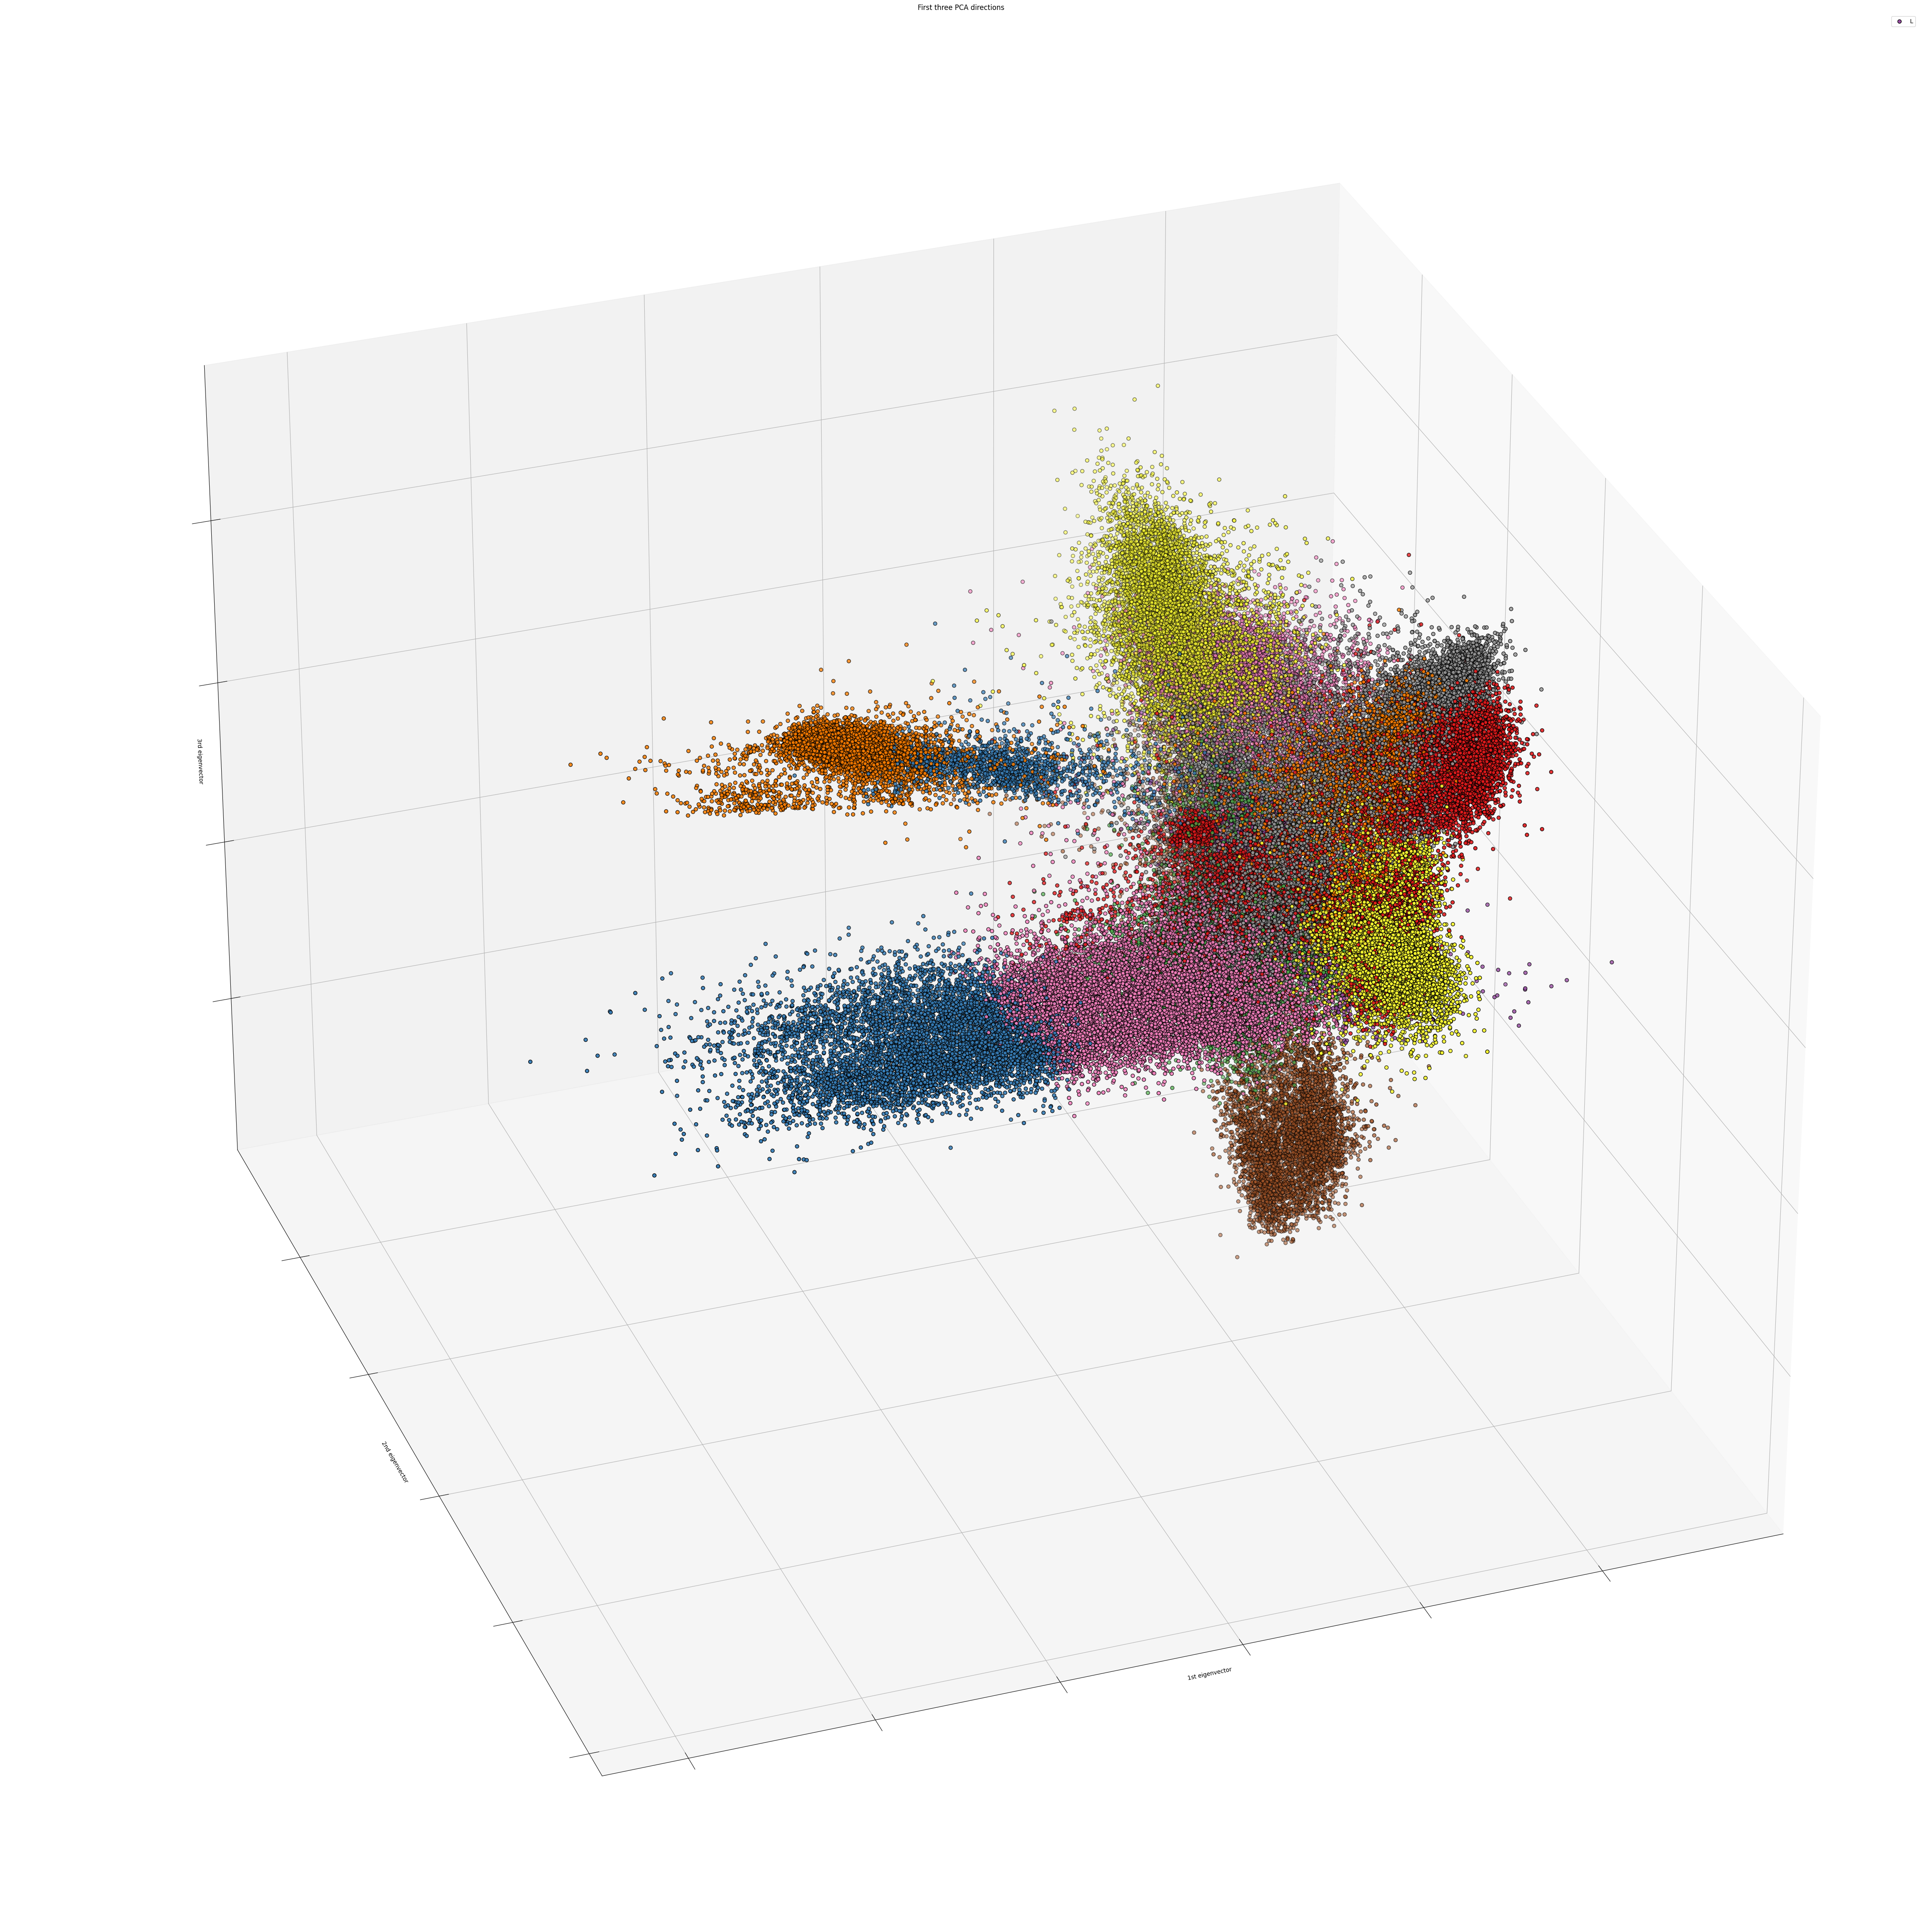

In [ ]:
fig = plt.figure(1, figsize=(80, 60))
ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)

X_reduced = PCA(n_components=3).fit_transform(arr)
ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    X_reduced[:, 2],
    c=y,
    cmap=plt.cm.Set1,
    edgecolor="k",
    s=40
)

ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.zaxis.set_ticklabels([])
plt.legend('Legend')


plt.show()

In [ ]:
fig.savefig('images/y_cluster.png', dpi=fig.dpi) #change